In [1]:
from pandas import read_csv
data = read_csv('./Wholesale customers data.csv')

In [2]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
for column in data.columns:
    print(column, '\t', len(data[column]),len(set(data[column])))

Channel 	 440 2
Region 	 440 3
Fresh 	 440 433
Milk 	 440 421
Grocery 	 440 430
Frozen 	 440 426
Detergents_Paper 	 440 417
Delicassen 	 440 403


In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

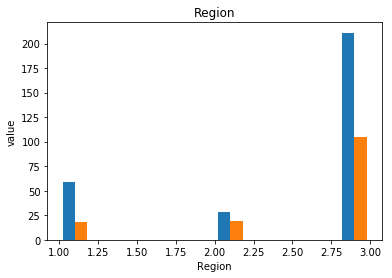

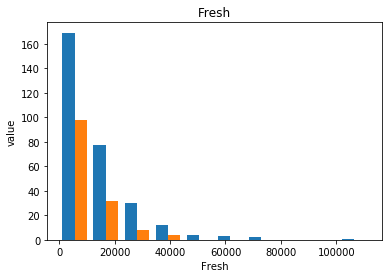

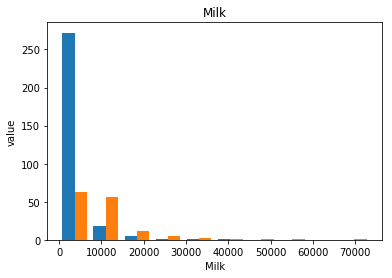

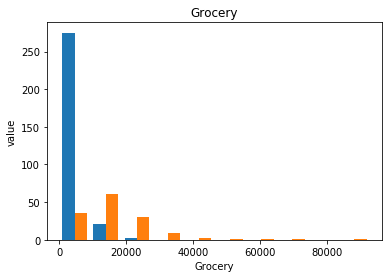

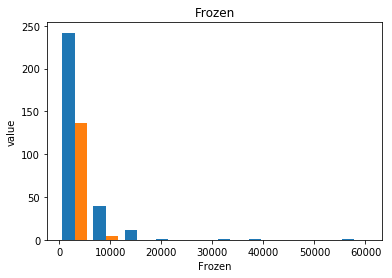

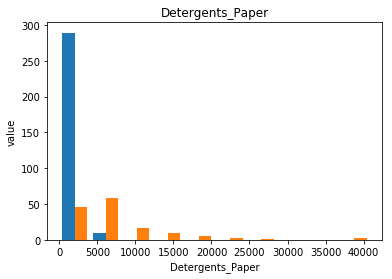

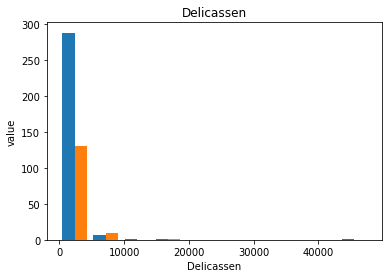

In [5]:
for column in data.columns[1:]:
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('value')
    x1 = data[data.Channel == 1][column]
    x2 = data[data.Channel == 2][column]
    plt.hist([x1, x2])
    plt.show()

In [6]:
# в соответствии с интервалами преобразуем признаки в бинарные: если interval=True, то конечные,
# если False, то бесконечные (>=)

def make_data(interval_dict, data, interval=True):
    data_dict = {}
    for column, intervals in interval_dict.items():
        for ind, (lower, upper) in enumerate(zip(intervals[:-1], intervals[1:])):
            if not interval:
                data_dict[column + str(ind+1)] = (data[column] >= lower).astype(int)
            else:
                data_dict[column + str(ind+1)] = ((data[column] >= lower) & (data[column] <= upper)).astype(int)

    data_dict['Target'] = data.Channel - 1
    return DataFrame(data_dict)

In [7]:
def plus_context(attributes, targets):
    return attributes[targets == 1]

def minus_context(attributes, targets):
    return attributes[targets == 0]

def score(sample, attributes, targets):
    plus = plus_context(attributes, targets).get_values()
    minus = minus_context(attributes, targets).get_values()
    value1 = 0
    value2 = 0
    for example in plus:
        candidate = example & sample
        closure = [ item for item in minus if ((item | candidate) == item).all() ]
        closure_size = len(closure)
        #print('plus_context in minus', closure_size)
        value1 += closure_size/len(minus)
    value1 /= len(plus)
        
    for example in minus:
        candidate = example & sample
        closure = [ item for item in plus if ((item | candidate) == item).all() ]
        closure_size = len(closure)
        #print('minus_context in plus', closure_size)
        value2 += closure_size/len(plus)
    value2 /= len(minus)
    return value1, value2

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def print_metrics(preds, y):
    print('accuracy: ', accuracy_score(preds, y))
    print('precision: ', precision_score(preds, y))
    print('recall: ', recall_score(preds, y))
    print('f1 score: ', f1_score(preds, y))

Преобразование целочисленных признаков в бинарные: разбиваем каждый признак на intervals_count интервалов

In [9]:
interval_dict = {}
intervals_count = 8
for column in data.columns[1:]:
    values = sorted(data[column])
    interval_dict[column] = [0] + [values[int(len(values)/intervals_count * n)] for n in range(1, min(intervals_count, 1 + len(set(values))))]
    interval_dict[column] = interval_dict[column] + [5*max(data[column])]

In [10]:
# посмотрим на интервалы
interval_dict

{'Region': [0, 1, 2, 3, 15],
 'Fresh': [0, 1406, 3136, 5809, 8533, 11635, 16936, 24929, 560755],
 'Milk': [0, 944, 1534, 2374, 3634, 5139, 7209, 11093, 367490],
 'Grocery': [0, 1499, 2155, 3045, 4757, 7021, 10685, 16267, 463900],
 'Frozen': [0, 364, 744, 1042, 1535, 2367, 3570, 6386, 304345],
 'Detergents_Paper': [0, 139, 257, 436, 820, 1716, 3961, 6830, 204135],
 'Delicassen': [0, 225, 409, 684, 967, 1333, 1824, 2708, 239715]}

In [11]:
from pandas import DataFrame
frame = make_data(interval_dict, data)
frame.head()

,Region1,Region2,Region3,Region4,Fresh1,Fresh2,Fresh3,Fresh4,Fresh5,Fresh6,...,Detergents_Paper8,Delicassen1,Delicassen2,Delicassen3,Delicassen4,Delicassen5,Delicassen6,Delicassen7,Delicassen8,Target
0,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


Модель: для каждого пересечения тестируемого примера и примера из положительного контекста считаем поддержку в отрицательном контексте и берем среднее по числу положительных примеров - это minus_score. Аналогично получаем plus_score. Если разинца между этими значениями больше некоторого порога, считаем пример отрицательным

In [18]:
from sklearn.model_selection import train_test_split
attributes = frame[frame.columns[:-1]]
targets = frame.Target
x_train, x_test, y_train, y_test = train_test_split(attributes, targets)

answers = []
scores = []
for i, item in (enumerate(x_test.get_values())):
    minus_score, plus_score = score(item, x_train, y_train)
    if minus_score - plus_score > -0.1:
        answers.append(0)
    else:
        answers.append(1)
    scores.append([y_test.get_values()[i], minus_score-plus_score])
scores = np.array(scores)

In [19]:
# при разбиении данных на 8 интервалов
print(accuracy_score(y_test, answers))
print(precision_score(y_test, answers))
print(recall_score(y_test, answers))
print(f1_score(y_test, answers)) 

0.9181818181818182
0.875
0.8484848484848485
0.8615384615384615


В ходе эксперимента было установлено, что лучшее значение accuracy и f1 score достигается при пороге 0.1 и количестве интервалов 8 (accuracy=0.92, f1=0.87). При разбиении на меньшее число интервалов качество падает.

### Support

Пробуем классифицировать, используя поддержку в качестве аггрегатной функции

In [20]:
def support(item, attributes, targets):
    plus = plus_context(attributes, targets).get_values()
    minus = minus_context(attributes, targets).get_values()
    plus_supp = len([i for i in range(len(plus)) if (item | plus[i] == plus[i]).all()])/len(plus)
    minus_supp = len([i for i in range(len(minus)) if (item | minus[i] == minus[i]).all()])/len(minus)
    return plus_supp, minus_supp

Если разница между поддержкой в положительном контексте и отрицательном больше некоторого порога, считаем объект положительным

In [21]:
def predict_support(item, attributes, targets, treshold=0):
    plus_supp, minus_supp = support(item, attributes, targets)
    if plus_supp - minus_supp > treshold:
        return 1
    return 0

Так как тут мы ищем поддержку тестируемого примера в плюс и минус контекстах, выгоднее использовать признаки с бесконечными интервалами, так как в противном случае признаки слишком разрежены и может не найтись вложения

In [23]:
frame = make_data(interval_dict, data, False)

In [24]:
frame.head()

,Region1,Region2,Region3,Region4,Fresh1,Fresh2,Fresh3,Fresh4,Fresh5,Fresh6,...,Detergents_Paper8,Delicassen1,Delicassen2,Delicassen3,Delicassen4,Delicassen5,Delicassen6,Delicassen7,Delicassen8,Target
0,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0,0,1
1,1,1,1,1,1,1,1,1,0,0,...,0,1,1,1,1,1,1,0,0,1
2,1,1,1,1,1,1,1,1,0,0,...,0,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1


Тестируем модель:

In [26]:
attributes = frame[frame.columns[:-1]]
targets = frame.Target
x_train, x_test, y_train, y_test = train_test_split(attributes, targets)

ans = []
for item in x_test.get_values():
    ans.append(predict_support(item, x_train, y_train))
ans = np.array(ans)
print_metrics(y_test, ans)

accuracy:  0.6181818181818182
precision:  0.5116279069767442
recall:  1.0
f1 score:  0.676923076923077


При таком подходе получаем высокий recall, но низкий precision.

In [34]:
from sklearn.ensemble import RandomForestClassifier
x_train, x_test, y_train, y_test = train_test_split(attributes, targets)

classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9272727272727272